In [1]:
import pandas as pd
import lightgbm as lgb

import lazypredict
from lazypredict.Supervised import LazyClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
df = pd.read_csv("Dataset/Tree_Data.csv")
df.head()

,No,Plot,Subplot,Species,Light_ISF,Light_Cat,Core,Soil,Adult,Sterile,...,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event,Harvest,Alive
0,126,1,C,Acer saccharum,0.11,Med,2017,Prunus serotina,I,Non-Sterile,...,22.00,NaN,-0.56,13.86,12.15,4,14.00,1.00,NaN,NaN
1,11,1,C,Quercus alba,0.11,Med,2017,Quercus rubra,970,Non-Sterile,...,15.82,31.07,5.19,20.52,19.29,33,115.50,0.00,NaN,X
2,12,1,C,Quercus rubra,0.11,Med,2017,Prunus serotina,J,Non-Sterile,...,24.45,28.19,3.36,24.74,15.01,18,63.00,1.00,NaN,NaN
3,2823,7,D,Acer saccharum,0.08,Med,2016,Prunus serotina,J,Non-Sterile,...,22.23,NaN,-0.71,14.29,12.36,4,14.00,1.00,NaN,NaN
4,5679,14,A,Acer saccharum,0.06,Low,2017,Prunus serotina,689,Non-Sterile,...,21.15,NaN,-0.58,10.85,11.20,4,14.00,1.00,NaN,NaN


## Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2783 entries, 0 to 2782
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No           2783 non-null   int64  
 1   Plot         2783 non-null   int64  
 2   Subplot      2783 non-null   object 
 3   Species      2783 non-null   object 
 4   Light_ISF    2783 non-null   float64
 5   Light_Cat    2783 non-null   object 
 6   Core         2783 non-null   int64  
 7   Soil         2783 non-null   object 
 8   Adult        2783 non-null   object 
 9   Sterile      2783 non-null   object 
 10  Conspecific  2783 non-null   object 
 11  Myco         2783 non-null   object 
 12  SoilMyco     2783 non-null   object 
 13  PlantDate    2783 non-null   object 
 14  AMF          2783 non-null   float64
 15  EMF          1283 non-null   float64
 16  Phenolics    2783 non-null   float64
 17  Lignin       2783 non-null   float64
 18  NSC          2783 non-null   float64
 19  Census

All columns with the data type of object was collected to convert to a float later. The ones not selected were to be removed which is further explained later.

In [4]:
columns = ["Subplot", "Species", "Soil", "Adult", "Sterile", "Conspecific", "Myco", "SoilMyco"]

In [5]:
df.nunique()

No             2783
Plot             18
Subplot           5
Species           4
Light_ISF        53
Light_Cat         3
Core              2
Soil              7
Adult            36
Sterile           2
Conspecific       3
Myco              2
SoilMyco          3
PlantDate        19
AMF             924
EMF             682
Phenolics       494
Lignin         1095
NSC             998
Census           22
Time             22
Event             2
Harvest           1
Alive             1
dtype: int64

In [6]:
df.isnull().sum()

No                0
Plot              0
Subplot           0
Species           0
Light_ISF         0
Light_Cat         0
Core              0
Soil              0
Adult             0
Sterile           0
Conspecific       0
Myco              0
SoilMyco          0
PlantDate         0
AMF               0
EMF            1500
Phenolics         0
Lignin            0
NSC               0
Census            0
Time              0
Event             1
Harvest        2079
Alive          2292
dtype: int64

In [7]:
df = df.drop(columns=["No", "EMF", "Harvest", "Alive", "Light_Cat", "PlantDate"])

Here are the reasons that the columns were removed.<br>
No was removed because it was simply an ID for the tree.<br>
EMF, Harvest, and Alive were removed because they had too many null values. I could not determine what the value could be after reviewing the dataset, so I decided to remove them altogether to keep a plump dataset.<br>
Light_Cat was removed because it was redundant since Light_ISF offered much information for the amount of light a tree obtained.<br>
PlantDate was removed because tests to see if the month affected the tree did not matter. This is likely due to the test being done in a contained environment removing external factors like the year's season.

In [8]:
df = df.dropna(subset=["Event"])

In [9]:
for col in df[columns]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    df[col] = df[col].astype("int")

LabelEncoder was used here to convert the categorical or object columns into numerical ones, so the model would be able to use them.

In [10]:
df.corr()

,Plot,Subplot,Species,Light_ISF,Core,Soil,Adult,Sterile,Conspecific,Myco,SoilMyco,AMF,Phenolics,Lignin,NSC,Census,Time,Event
Plot,1.00,0.01,0.02,0.25,0.04,-0.01,-0.01,-0.01,-0.02,0.01,-0.01,0.08,0.04,-0.01,0.03,-0.06,-0.06,-0.07
Subplot,0.01,1.00,0.01,0.09,0.04,0.01,0.03,0.02,-0.01,0.01,0.01,-0.01,0.01,0.02,0.02,0.00,0.00,-0.00
Species,0.02,0.01,1.00,0.00,0.11,0.03,0.03,0.03,0.03,0.89,0.02,-0.03,0.82,0.77,0.50,0.33,0.33,-0.55
Light_ISF,0.25,0.09,0.00,1.00,0.05,-0.01,-0.00,-0.01,-0.02,0.00,-0.01,0.10,0.10,0.08,0.23,0.02,0.02,-0.05
Core,0.04,0.04,0.11,0.05,1.00,0.15,0.16,0.10,0.06,0.09,-0.02,-0.06,0.05,0.09,0.05,0.05,0.05,-0.05
Soil,-0.01,0.01,0.03,-0.01,0.15,1.00,0.18,0.62,0.41,0.03,0.82,-0.28,-0.03,0.03,-0.04,0.01,0.01,-0.04
Adult,-0.01,0.03,0.03,-0.00,0.16,0.18,1.00,0.06,-0.01,-0.01,-0.04,0.04,-0.04,-0.01,-0.05,-0.01,-0.01,0.01
Sterile,-0.01,0.02,0.03,-0.01,0.10,0.62,0.06,1.00,0.77,0.03,0.76,-0.38,-0.07,-0.00,-0.04,0.04,0.04,-0.08
Conspecific,-0.02,-0.01,0.03,-0.02,0.06,0.41,-0.01,0.77,1.00,0.03,0.61,-0.27,-0.05,-0.02,0.03,0.04,0.04,-0.08
Myco,0.01,0.01,0.89,0.00,0.09,0.03,-0.01,0.03,0.03,1.00,0.02,-0.24,0.94,0.88,0.72,0.38,0.38,-0.60


In [11]:
s_columns_rm = ["Subplot"]

In [12]:
df = df.drop(columns=s_columns_rm)

From all the attempts made, removing only Subplot gave the best results. As seen in the correlation table above, Subplot did not correlate for all but one column (though it was still a very weak correlation of 0.09).

## Train_Test_Split

In [13]:
y = df["Event"]
X = df.drop(columns=["Event"])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,Plot,Species,Light_ISF,Core,Soil,Adult,Sterile,Conspecific,Myco,SoilMyco,AMF,Phenolics,Lignin,NSC,Census,Time
361,6,1,0.09,2017,6,33,1,2,0,2,8.73,0.06,7.69,11.93,7,24.50
1845,12,1,0.06,2016,5,16,0,1,0,1,21.36,0.68,6.47,10.46,12,42.00
1337,18,0,0.14,2016,4,14,0,1,0,1,16.14,0.31,14.16,13.01,7,24.50
1601,11,0,0.06,2017,5,30,0,1,0,1,13.31,0.01,10.11,10.79,11,38.50
2600,16,2,0.13,2016,2,21,0,1,1,1,30.28,5.26,18.88,23.64,15,52.50


## LazyPredict

In [15]:
clf_laz = LazyClassifier(verbose=0, ignore_warnings=True)
lazy_model, lazy_pred_str = clf_laz.fit(X_train, X_test, y_train, y_test)
lazy_model

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 12.94it/s]

[LightGBM] [Info] Number of positive: 1185, number of negative: 901
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1200
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568073 -> initscore=0.273993
[LightGBM] [Info] Start training from score 0.273993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.98,0.97,0.97,0.98,0.12
XGBClassifier,0.97,0.97,0.97,0.97,0.08
BaggingClassifier,0.97,0.97,0.97,0.97,0.05
RandomForestClassifier,0.97,0.97,0.97,0.97,0.28
DecisionTreeClassifier,0.97,0.96,0.96,0.97,0.02
ExtraTreesClassifier,0.96,0.96,0.96,0.96,0.15
AdaBoostClassifier,0.96,0.96,0.96,0.96,0.13
SVC,0.95,0.95,0.95,0.95,0.09
ExtraTreeClassifier,0.91,0.91,0.91,0.91,0.01


From what lazypredict was able to do, I decided that I would use LGBMClassifier.

##  Creating the model

In [16]:
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1185, number of negative: 901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568073 -> initscore=0.273993
[LightGBM] [Info] Start training from score 0.273993


LGBMClassifier()

No parameters were changed as it only made the model perform worse.

In [17]:
predictions = model_lgb.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       294
         1.0       0.98      0.99      0.98       402

    accuracy                           0.98       696
   macro avg       0.98      0.98      0.98       696
weighted avg       0.98      0.98      0.98       696



In [18]:
print(f"Training Model Score: {model_lgb.score(X_train, y_train)}")
print(f"Testing Model Score: {model_lgb.score(X_test, y_test)}")

Training Model Score: 1.0
Testing Model Score: 0.9770114942528736


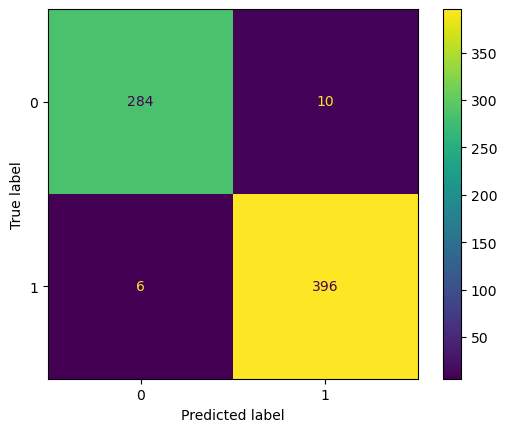

In [19]:
cm = confusion_matrix(y_test, predictions)

cm_display = ConfusionMatrixDisplay(cm).plot()